In [63]:
%matplotlib inline
from config import pword
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
# from config import password 

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
spark = SparkSession.builder.appName('pyspark_app') \
.config('spark.driver.extraClassPath','postgresql-42.2.11') \
.master('local[*]') \
.getOrCreate()


In [4]:
from pyspark import SparkFiles
from pyspark.sql.functions import to_date
from pyspark.sql.functions import round, col

In [11]:
#path for toys
url2 = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Toys_v1_00.tsv.gz"

In [12]:
#add url file
spark.sparkContext.addFile(url2)

In [14]:
df = spark.read.option("header", "true").csv(SparkFiles.get
                                             ("amazon_reviews_us_Toys_v1_00.tsv.gz"), inferSchema=True, sep='\t')

In [15]:
print(f'There are {df.count()} rows in the video game dataframe')

There are 4864249 rows in the video game dataframe


In [16]:
#create column in correct date format
df = df.withColumn("date", to_date(df['review_date']))

In [17]:
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: timestamp (nullable = true)
 |-- date: date (nullable = true)



In [18]:
#create reviews df
review_df = df.select(["review_id", "customer_id", "product_id", "product_parent", "date"])
review_df.show(5)

+--------------+-----------+----------+--------------+----------+
|     review_id|customer_id|product_id|product_parent|      date|
+--------------+-----------+----------+--------------+----------+
| RDIJS7QYB6XNR|   18778586|B00EDBY7X8|     122952789|2015-08-31|
|R36ED1U38IELG8|   24769659|B00D7JFOPC|     952062646|2015-08-31|
| R1UE3RPRGCOLD|   44331596|B002LHA74O|     818126353|2015-08-31|
|R298788GS6I901|   23310293|B00ARPLCGY|     261944918|2015-08-31|
|  RNX4EXOBBPN5|   38745832|B00UZOPOFW|     717410439|2015-08-31|
+--------------+-----------+----------+--------------+----------+
only showing top 5 rows



In [19]:
review_df = review_df.filter(review_df['date'].isNotNull())
review_df = review_df.orderBy(review_df['date'].asc())
review_df.show()

+--------------+-----------+----------+--------------+----------+
|     review_id|customer_id|product_id|product_parent|      date|
+--------------+-----------+----------+--------------+----------+
|R1HN7EVNEN51LR|   52981203|087431254X|     828464997|1997-01-05|
|R13AWVNEKSY9M1|   51898365|0786902345|     219342170|1998-06-11|
|R17ULZ2VC0O3CG|   52552376|0786901438|     842160633|1998-07-27|
|R3K9ZYANG0OFJB|   52359446|0786901438|     842160633|1998-10-12|
|R1UP8F8Y4GC3IE|   52633682|0811821587|     713499567|1998-11-08|
|R3NKPKIBIWQH3Z|   52290892|0811821587|     713499567|1998-11-15|
|R2R8VT48Z9HZUB|   52869502|B00000DMBQ|     419014956|1998-11-18|
| R3LS3DOYDLPFE|   52912621|B00000DMBD|     141217454|1998-11-18|
|R1VLOYQSQYGTW0|   50986568|B00000DMBQ|     419014956|1998-11-19|
|R39WQRXHE773AZ|   52702559|B00000DMER|     579979198|1998-11-19|
|R1LGX0XI8HMJD5|   52551381|B00000DMDO|      48281612|1998-11-19|
|R1QAWI39L1RP6L|   51715163|0811821587|     713499567|1998-11-20|
|R1E0ZP5W6

In [20]:
#create customer df with unique custy id
custy_df = df.groupBy('customer_id').count()

In [21]:
#rename count col
custy_df = custy_df.withColumnRenamed('count','customer_count')

In [22]:
custy_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|   16989307|             1|
|   45632184|             2|
|   14703850|            13|
|   49645387|             2|
|   16343477|             1|
+-----------+--------------+
only showing top 5 rows



In [23]:
#create prod df with unique prod id
prod_df = df.select(["product_id", "product_title"])
prod_df = prod_df.dropDuplicates(['product_id'])

In [24]:
prod_df.count()

664062

In [33]:
#create vine df
vine_df = df.select(["review_id", "star_rating", "helpful_votes", "total_votes", "vine"])
vine_df.show(5)
vine_df.printSchema()

+--------------+-----------+-------------+-----------+----+
|     review_id|star_rating|helpful_votes|total_votes|vine|
+--------------+-----------+-------------+-----------+----+
| RDIJS7QYB6XNR|          5|            0|          0|   N|
|R36ED1U38IELG8|          5|            0|          0|   N|
| R1UE3RPRGCOLD|          2|            1|          1|   N|
|R298788GS6I901|          5|            0|          0|   N|
|  RNX4EXOBBPN5|          1|            1|          1|   N|
+--------------+-----------+-------------+-----------+----+
only showing top 5 rows

root
 |-- review_id: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)



In [26]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://big-data-2.cpclfqan17p9.us-east-1.rds.amazonaws.com:5432/bd-homework"
config = {"user":"postgres", 
          "password": pword, 
          "driver":"org.postgresql.Driver"}

In [27]:
#write reviews to RDS
review_df.write.jdbc(url=jdbc_url, table='toy_review_id_table', mode=mode, properties=config)

In [28]:
#write customers
custy_df.write.jdbc(url=jdbc_url, table='toy_customers', mode=mode, properties=config)

In [29]:
#write products
prod_df.write.jdbc(url=jdbc_url, table='toy_products', mode=mode, properties=config)

In [30]:
#write vine
vine_df.write.jdbc(url=jdbc_url, table='toy_vine_table', mode=mode, properties=config)

In [35]:
#import functions
from pyspark.sql.functions import count, avg, sum

In [64]:
#create function to run analysis on reviews in ("Y") and out of ("N") vine program 
def vine_program(yes_no):
    #dopr all rows that have no votes
    filter_df = vine_df.filter(vine_df["total_votes"]>0)
    df = filter_df.filter(vine_df["vine"] == yes_no).groupBy('star_rating').count()
    #rename count col
    df = df.withColumnRenamed('count','star_count')
    #count vine reviews
    total = df.groupBy().sum('star_count').collect()[0][0]
    print(f'There are {total} reviews with vine marker {yes_no} and at least one vote')
    #create percent of total column
    df = df.withColumn('star_pct',round(df['star_count']/total,4))
    #get total number of helpful votes by star rating
    df_help = vine_df.filter(vine_df["vine"] == yes_no).groupBy('star_rating').agg(sum('helpful_votes'),sum('total_votes'))
    #rename helpful votes col
    df_help = df_help.withColumnRenamed('sum(helpful_votes)', 'helpful_votes').withColumnRenamed('sum(total_votes)',
                                                                                                 'total_votes')
    #join helpful votes to vine ratings
    df = df.join(df_help,['star_rating'])
    #create column which averages # of helpful votes by star
    df = df.withColumn('helpful_avg',round(df['helpful_votes']/df['star_count'],4))
    df = df.withColumn('helpful_ratio',round(df['helpful_votes']/df['total_votes'],4))
    
    #order by star rating
    df = df.orderBy(df['star_rating'].asc())
    #show schema
    df.printSchema()
    global pandas_df
    pandas_df = df.toPandas()
    if yes_no == "Y":
        color = "blue"
        title = "Vine"
    else:
        color = "red"
        title = "Non-Vine"
        
    #plot number of reviews by star rating
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['star_pct'], color =color)
    plt.title(f"{title} Reviews", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("% of Ratings", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"images/{title}_toy_reviews.png")
    #plot average of helpful votes per review by star ratings
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['helpful_avg'], color =color)
    plt.title(f"Avg # of Helpful Votes per {title} Review", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("Average", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"images/{title}_toy_help_avg.png")
    #plot helpful vote ratio by star ratings
    plt.figure(figsize=(10,6))
    plt.bar(pandas_df['star_rating'],pandas_df['helpful_ratio'], color =color)
    plt.title(f"Helpful Vote Ratio for {title} Reviews", fontsize=20)
    plt.xlabel("Star Rating", fontsize=16)
    plt.ylabel("Percent", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(f"images/{title}_toy_ratio.png")
    #save pandas_df as csv
    pandas_df.to_csv(f"{yes_no}_toy_summary.csv", index=False)
    return df.show()
    
    

There are 21240 reviews with vine marker Y and at least one vote
root
 |-- star_rating: integer (nullable = true)
 |-- star_count: long (nullable = false)
 |-- star_pct: double (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- total_votes: long (nullable = true)
 |-- helpful_avg: double (nullable = true)
 |-- helpful_ratio: double (nullable = true)

+-----------+----------+--------+-------------+-----------+-----------+-------------+
|star_rating|star_count|star_pct|helpful_votes|total_votes|helpful_avg|helpful_ratio|
+-----------+----------+--------+-------------+-----------+-----------+-------------+
|          1|       426|  0.0201|         2945|       4131|     6.9131|       0.7129|
|          2|      1172|  0.0552|         6784|       8826|     5.7884|       0.7686|
|          3|      3765|  0.1773|        25450|      30869|     6.7596|       0.8245|
|          4|      7616|  0.3586|        38339|      46127|      5.034|       0.8312|
|          5|      8261|  0.38

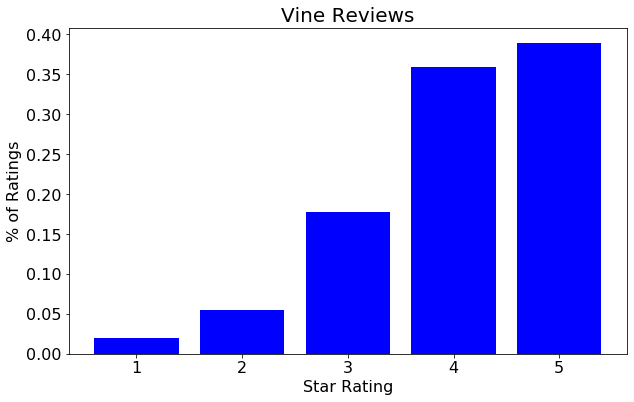

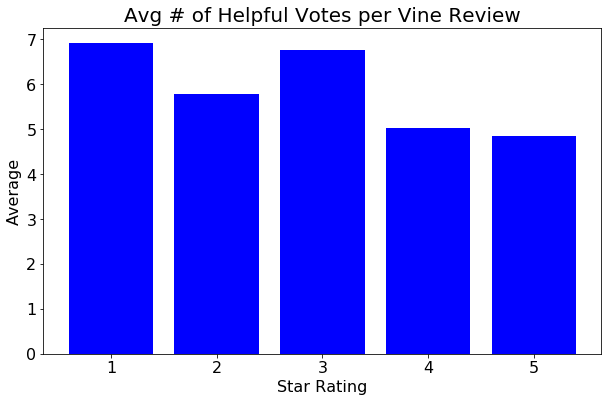

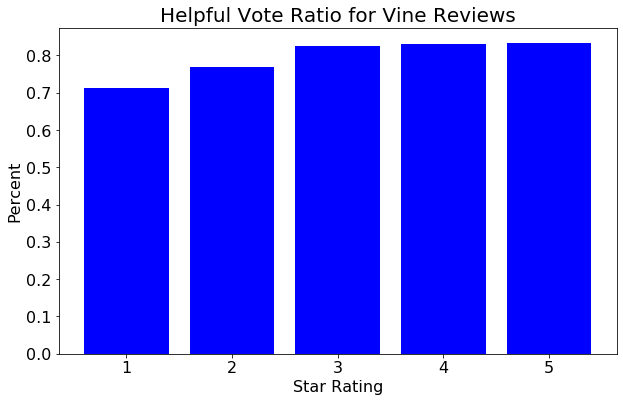

In [65]:
vine_program("Y")

There are 1831664 reviews with vine marker N and at least one vote
root
 |-- star_rating: integer (nullable = true)
 |-- star_count: long (nullable = false)
 |-- star_pct: double (nullable = true)
 |-- helpful_votes: long (nullable = true)
 |-- total_votes: long (nullable = true)
 |-- helpful_avg: double (nullable = true)
 |-- helpful_ratio: double (nullable = true)

+-----------+----------+--------+-------------+-----------+-----------+-------------+
|star_rating|star_count|star_pct|helpful_votes|total_votes|helpful_avg|helpful_ratio|
+-----------+----------+--------+-------------+-----------+-----------+-------------+
|          1|    250312|  0.1367|      1090978|    1684065|     4.3585|       0.6478|
|          2|    123261|  0.0673|       480539|     668503|     3.8985|       0.7188|
|          3|    179277|  0.0979|       700301|     924949|     3.9063|       0.7571|
|          4|    297343|  0.1623|      1180021|    1405786|     3.9686|       0.8394|
|          5|    981471|  0.

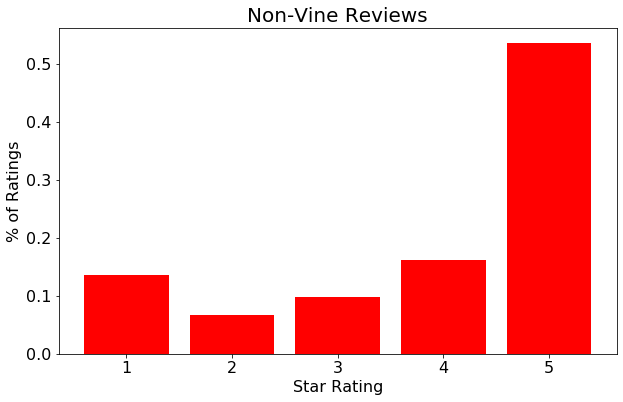

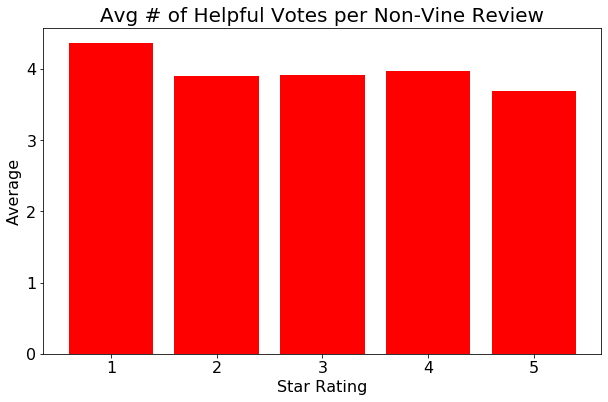

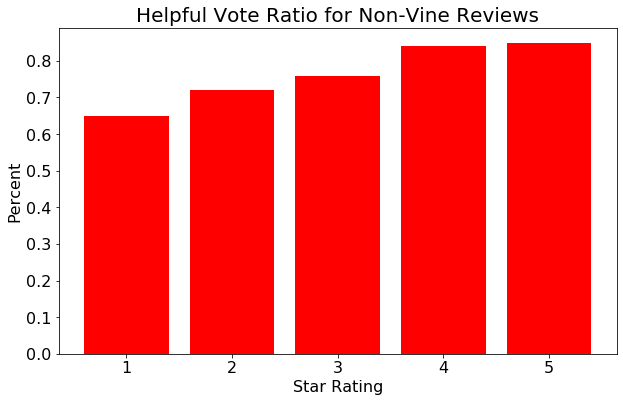

In [66]:
vine_program("N")

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number

In [60]:
def custy_analysis(yes_no):
    cust_check_df =  df.select(["customer_id", "star_rating", "helpful_votes", "total_votes", "vine"])
    #filter for interviewers in the vine program and received at least one vote
    cust_check_df = cust_check_df.filter(cust_check_df['vine'] == yes_no).filter(cust_check_df['total_votes']>0)
    #group by customer id, get average star_rating, sum helpful_votes and sum total_votes
    group_cust_df = cust_check_df.groupBy("customer_id").agg(count("customer_id"),avg("star_rating"), sum("helpful_votes"),
                                                             sum("total_votes"))
    #rename columns
    group_cust_df = group_cust_df.withColumnRenamed('count(customer_id)', 'total_reviews').withColumnRenamed('avg(star_rating)',
                            'avg_rating').withColumnRenamed('sum(helpful_votes)','total_helpful_votes').withColumnRenamed(
                            'sum(total_votes)','total_votes')
    #sort by total reviews
    group_cust_df = group_cust_df.orderBy(group_cust_df['total_reviews'].asc())
    #add index columns
    w = Window.orderBy("total_reviews") 
    group_cust_df = group_cust_df.withColumn("index", row_number().over(w))
    #create top reviewers dataframe. Interviewers have at least 10 reviews
    top_cust_df = group_cust_df.filter(group_cust_df['total_reviews'] >= 10)
    #count number of top reviewers
    top = top_cust_df.count()
    #add column which gives ratio of helpful votes to total votes
    top_cust_df = top_cust_df.withColumn('helpful_ratio',round(top_cust_df['total_helpful_votes']/top_cust_df['total_votes'],4))
    #sort by helpful_ratio
    top_cust_df = top_cust_df.orderBy(top_cust_df['helpful_ratio'].asc())
    #count total number of interviews with a helpful ration below 50%
    low_help_df = top_cust_df.filter(top_cust_df['helpful_ratio']<0.50)
    low = low_help_df.count()
    print(f'Percentage of top reviewers with low ratings {low/top}')
    

In [61]:
custy_analysis("Y")

Percentage of top reviewers with low ratings 0.0411522633744856


In [62]:
custy_analysis("N")

Percentage of top reviewers with low ratings 0.07190082644628099


In [67]:
y = pd.read_csv("Y_toy_summary.csv")
n = pd.read_csv("N_toy_summary.csv")

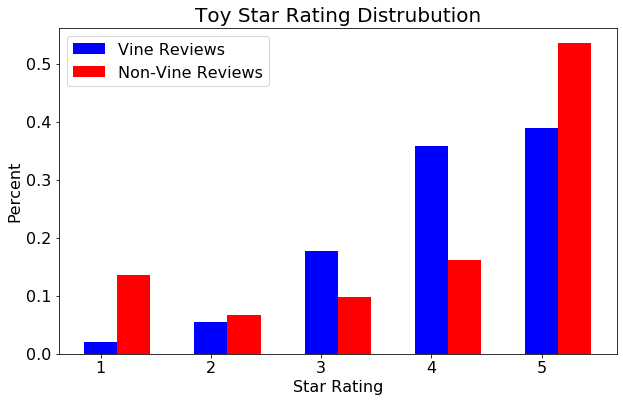

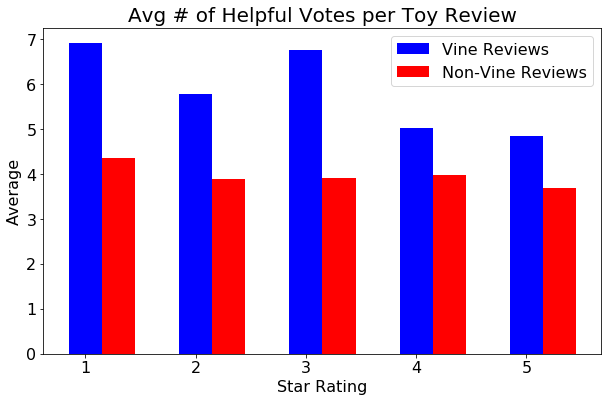

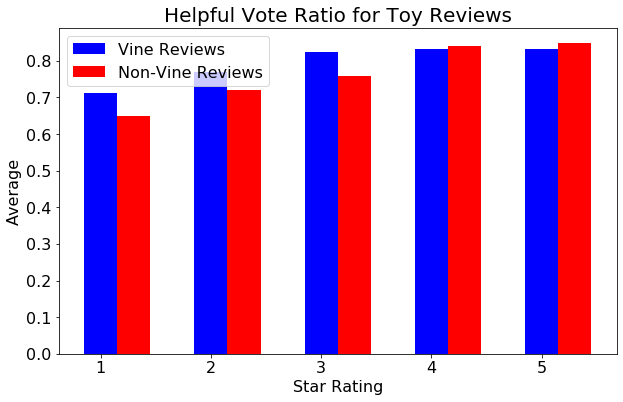

In [68]:
#side by side comparison for Star Rating Distribution
plt.figure(figsize=(10,6))
plt.bar(y['star_rating'],y['star_pct'], color = "blue", width = 0.3, label="Vine Reviews")
plt.bar(y['star_rating']+0.3,n['star_pct'], color = "red", width = 0.3, label="Non-Vine Reviews")
plt.title("Toy Star Rating Distrubution", fontsize=20)
plt.xlabel("Star Rating", fontsize=16)
plt.ylabel("Percent", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", fontsize=16)
plt.savefig("images/toy_total_disto.png")

#side by side comparison for Avg Number of Helpful Votes
plt.figure(figsize=(10,6))
plt.bar(y['star_rating'],y['helpful_avg'], color = "blue", width = 0.3, label="Vine Reviews")
plt.bar(y['star_rating']+0.3,n['helpful_avg'], color = "red", width = 0.3, label="Non-Vine Reviews")
plt.title("Avg # of Helpful Votes per Toy Review", fontsize=20)
plt.xlabel("Star Rating", fontsize=16)
plt.ylabel("Average", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", fontsize=16)
plt.savefig("images/toy_total_help_avg.png")

#side by side comparison of helpful vote ratio
plt.figure(figsize=(10,6))
plt.bar(y['star_rating'],y['helpful_ratio'], color = "blue", width = 0.3, label="Vine Reviews")
plt.bar(y['star_rating']+0.3,n['helpful_ratio'], color = "red", width = 0.3, label="Non-Vine Reviews")
plt.title("Helpful Vote Ratio for Toy Reviews", fontsize=20)
plt.xlabel("Star Rating", fontsize=16)
plt.ylabel("Average", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="best", fontsize=16)
plt.savefig("images/toy_total_help_ratio.png")
